# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [24]:
import pandas as pd
import numpy as np
import pandas.tseries
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load dataframe and print head to ensure it loaded correctly
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
df.isnull().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [5]:
df['City'].nunique()

7554

In [7]:
# df['State'].value_counts()

In [ ]:
# df_ca = df.copy()
# df_ca = df_ca[df_ca.State == 'CA']
# df_ca

In [8]:
df_or = df.copy()
df_or = df_or[df_or.State == 'OR']
df_or

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
135,99142,97229,Portland,OR,Portland,Multnomah,136,209800.0,209700.0,210700.0,...,561800,563100,565600,567700,569200,570000,570200,571500,573800,574800
285,99252,97402,Eugene,OR,Eugene,Lane,286,97800.0,98000.0,98200.0,...,226300,227800,229500,231300,233100,235000,237000,238400,239800,240900
418,99048,97045,Oregon City,OR,Portland,Clackamas,419,150000.0,150700.0,151200.0,...,373600,374600,376500,379200,381500,384400,387500,391400,397000,401700
458,99251,97401,Eugene,OR,Eugene,Lane,459,140500.0,141100.0,141700.0,...,319200,320200,321900,323400,324800,326800,329100,331400,334500,337000
539,99093,97124,Hillsboro,OR,Portland,Washington,540,149700.0,150500.0,151400.0,...,367900,369700,371800,372700,372800,373600,374300,375400,378700,381300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14523,99472,97886,Weston,OR,Hermiston-Pendleton,Umatilla,14524,NaN,NaN,NaN,...,133300,135600,138000,138700,138700,139600,140500,141200,142700,143800
14659,99017,97011,Brightwood,OR,Portland,Clackamas,14660,107000.0,107600.0,108300.0,...,253400,252500,252400,254000,257400,262800,267600,271700,279000,285600
14694,99114,97149,Neskowin,OR,NaN,Tillamook,14695,187900.0,188900.0,189700.0,...,394800,399000,402900,408800,418900,428100,433000,431600,421600,413400
14708,99401,97733,Crescent,OR,Klamath Falls,Klamath,14709,NaN,NaN,NaN,...,197700,203700,207900,208100,206400,208700,211800,218100,228400,238500


In [9]:
df_port = df_or.copy()
df_port = df_port[df_port.City == 'Portland']
df_port

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
135,99142,97229,Portland,OR,Portland,Multnomah,136,209800.0,209700.0,210700.0,...,561800,563100,565600,567700,569200,570000,570200,571500,573800,574800
644,99120,97206,Portland,OR,Portland,Multnomah,645,96600.0,97600.0,98600.0,...,371200,371600,371900,372000,373000,374900,377100,379600,381800,382200
999,99116,97202,Portland,OR,Portland,Multnomah,1000,132600.0,133400.0,134200.0,...,525600,523400,522700,521700,522200,525700,530100,534100,535900,535000
1438,99133,97219,Portland,OR,Portland,Multnomah,1439,165600.0,166400.0,167200.0,...,483100,482200,480800,480000,480500,482900,486600,490900,495000,496400
1769,99131,97217,Portland,OR,Portland,Multnomah,1770,90600.0,91500.0,92300.0,...,433700,434100,434000,433100,433600,436100,439100,442400,445100,445000
1820,99143,97230,Portland,OR,Portland,Multnomah,1821,134700.0,135500.0,136400.0,...,316900,319200,320700,321400,322700,325100,327800,330700,332900,333300
2406,99127,97213,Portland,OR,Portland,Multnomah,2407,121700.0,122900.0,124200.0,...,467800,466600,464800,463300,462800,463200,464000,465500,466300,465400
2419,99146,97233,Portland,OR,Portland,Multnomah,2420,110800.0,111500.0,112300.0,...,272800,274500,276000,277100,278600,280900,283600,286300,288400,288800
2520,99125,97211,Portland,OR,Portland,Multnomah,2521,88000.0,88700.0,89400.0,...,459000,458200,457500,456400,456100,458800,463200,468000,472300,474300
2557,99128,97214,Portland,OR,Portland,Multnomah,2558,136700.0,137700.0,138800.0,...,592100,591500,590000,587100,586200,589400,593800,597200,598000,596300


In [10]:
df_port.drop(labels=['City', 'State', 'Metro', 'SizeRank', 'CountyName', 
                     'RegionID'], axis=1, inplace=True)

# Step 2: Data Preprocessing

In [11]:
df_portmelt = df_port.melt( 
            id_vars=['RegionName'],
            var_name='Date', 
            value_name='Avg_Price')
df_portmelt


,RegionName,Date,Avg_Price
0,97229,1996-04,209800.0
1,97206,1996-04,96600.0
2,97202,1996-04,132600.0
3,97219,1996-04,165600.0
4,97217,1996-04,90600.0
...,...,...,...
6885,97218,2018-04,388400.0
6886,97205,2018-04,970900.0
6887,97221,2018-04,607700.0
6888,97227,2018-04,540300.0


In [12]:
df_portmelt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6890 entries, 0 to 6889
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  6890 non-null   int64  
 1   Date        6890 non-null   object 
 2   Avg_Price   6890 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 161.6+ KB


In [13]:
# Convert Date to datetime
df_portmelt['Date'] = pd.to_datetime(df_portmelt['Date'], format='%Y-%m')

# Convert RegionName to string as it will be used catergorical not quantatively
df_portmelt['RegionName'] = df_portmelt['RegionName'].astype(str)
df_portmelt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6890 entries, 0 to 6889
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  6890 non-null   object        
 1   Date        6890 non-null   datetime64[ns]
 2   Avg_Price   6890 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 161.6+ KB


## Initial EDA

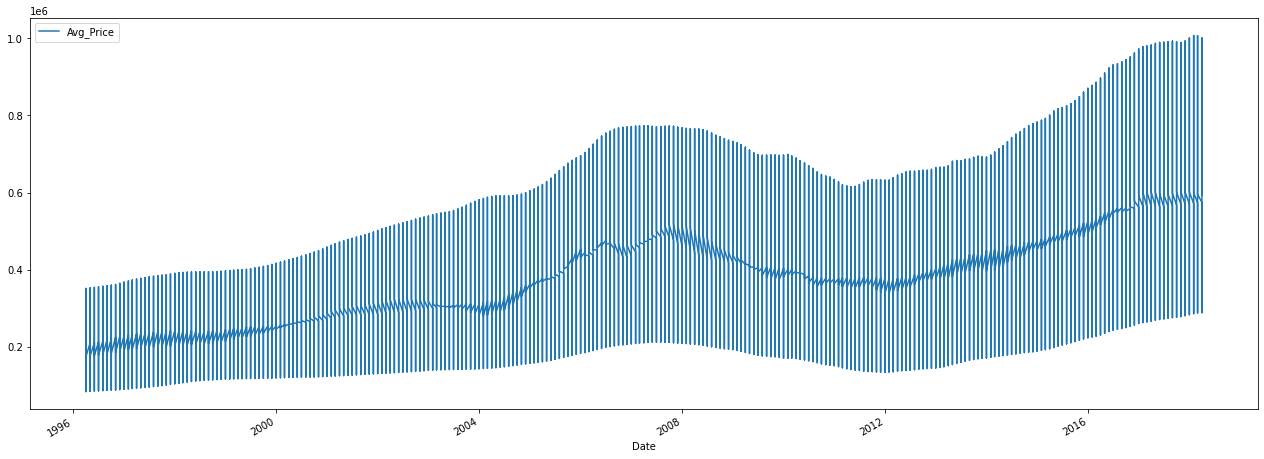

In [14]:
df_portmelt.plot(x='Date', y='Avg_Price', figsize = (22,8))
plt.show()

**CLEAN UP AND CLEAR UP** With this initial graph, we can see the overall pattern of all Portland throughout the years. We can she there is a general upward trend with a drop off in 2008 to 2012  which is indicative of the 2008 recession. **/**

In [21]:
df_portmelt

,RegionName,Date,Avg_Price
0,97229,1996-04-01,209800.0
1,97206,1996-04-01,96600.0
2,97202,1996-04-01,132600.0
3,97219,1996-04-01,165600.0
4,97217,1996-04-01,90600.0
...,...,...,...
6885,97218,2018-04-01,388400.0
6886,97205,2018-04-01,970900.0
6887,97221,2018-04-01,607700.0
6888,97227,2018-04-01,540300.0


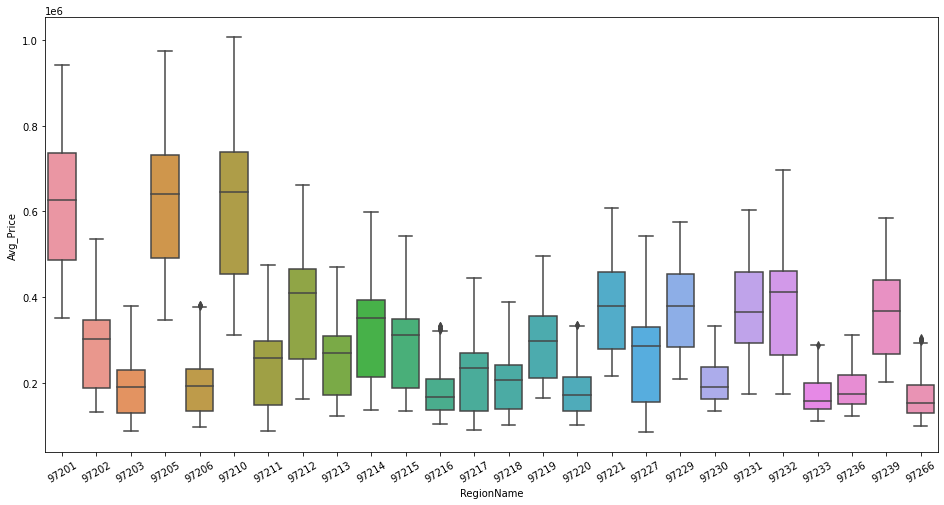

In [35]:
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x='RegionName', y='Avg_Price', data=df_portmelt)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

<AxesSubplot:xlabel='Date', ylabel='Avg_Price'>

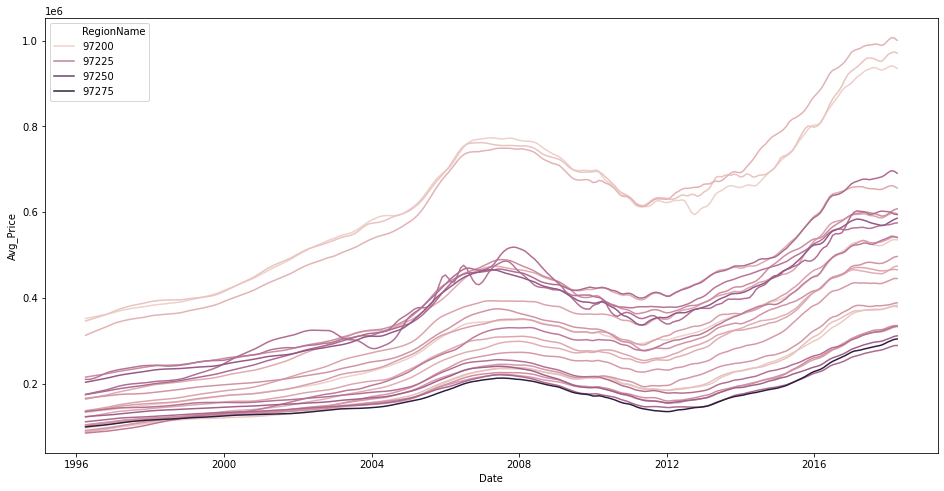

In [39]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=df_portmelt, x='Date', y='Avg_Price', hue='RegionName')

**Clean and Clear Up** We will use the above boxplot to choose which zipcodes from Portland to focus on first. We'll focus on the three highest average prices
- 97201
- 97205
- 97210

In [32]:
zip_list = list(df_portmelt['RegionName'].unique())
zip_list

['97229',
 '97206',
 '97202',
 '97219',
 '97217',
 '97230',
 '97213',
 '97233',
 '97211',
 '97214',
 '97236',
 '97266',
 '97203',
 '97220',
 '97212',
 '97201',
 '97239',
 '97232',
 '97215',
 '97210',
 '97216',
 '97218',
 '97205',
 '97221',
 '97227',
 '97231']

In [40]:
temp = df_portmelt.copy()
temp = temp.groupby('RegionName')
temp.first()

,Date,Avg_Price
RegionName,,
97201,1996-04-01,351700.0
97202,1996-04-01,132600.0
97203,1996-04-01,88000.0
97205,1996-04-01,345900.0
97206,1996-04-01,96600.0
97210,1996-04-01,312400.0
97211,1996-04-01,88000.0
97212,1996-04-01,163400.0
97213,1996-04-01,121700.0


In [41]:
temp.get_group(zip_list[0])

,Date,Avg_Price
0,1996-04-01,209800.0
26,1996-05-01,209700.0
52,1996-06-01,210700.0
78,1996-07-01,212800.0
104,1996-08-01,215700.0
...,...,...
6760,2017-12-01,570000.0
6786,2018-01-01,570200.0
6812,2018-02-01,571500.0
6838,2018-03-01,573800.0


In [ ]:
# for x in range(len(zip_list)):
#     temp.get_group(zip_list[x]).plot(x='Date', y='Avg_Price', figsize = (22,8))
#     print(zip_list[x])
#     plt.show()
# temp.get_group(zip_list[0]).plot(x='Date', y='Avg_Price', figsize = (22,8))
# plt.show()

# Functions


In [ ]:
# def get_datetimes(df):
#     return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [ ]:
# Reshape from Wide to Long Format
# def melt_data(df):
#     melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 
#                                   'CountyName', 'RegionID'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

# Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Test zipcode for model, EDA, ETC

In [44]:
temp97201 = temp.get_group('97201')
temp97201

,Date,Avg_Price
15,1996-04-01,351700.0
41,1996-05-01,353100.0
67,1996-06-01,354500.0
93,1996-07-01,355900.0
119,1996-08-01,357300.0
...,...,...
6775,2017-12-01,933800.0
6801,2018-01-01,938100.0
6827,2018-02-01,941300.0
6853,2018-03-01,939800.0


In [45]:
temp97201.set_index('Date', inplace=True)
temp97201.head()

,Avg_Price
Date,
1996-04-01,351700.0
1996-05-01,353100.0
1996-06-01,354500.0
1996-07-01,355900.0
1996-08-01,357300.0


array([[<AxesSubplot:title={'center':'Avg_Price'}>]], dtype=object)

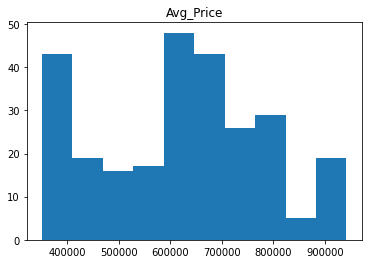

In [53]:
temp97201.hist(grid=False)

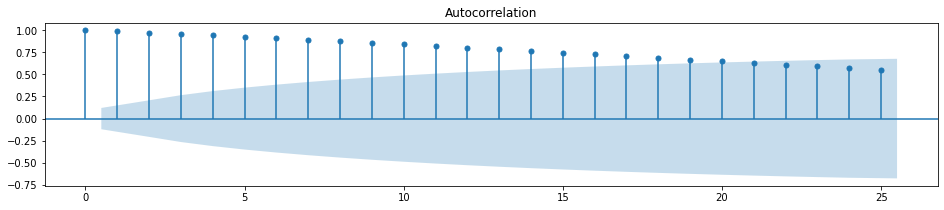

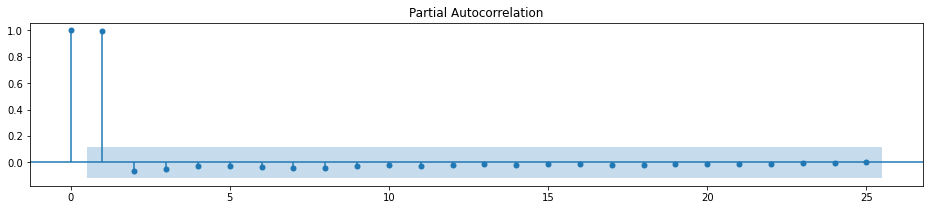

In [52]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(temp97201, ax=ax);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(temp97201, ax=ax);

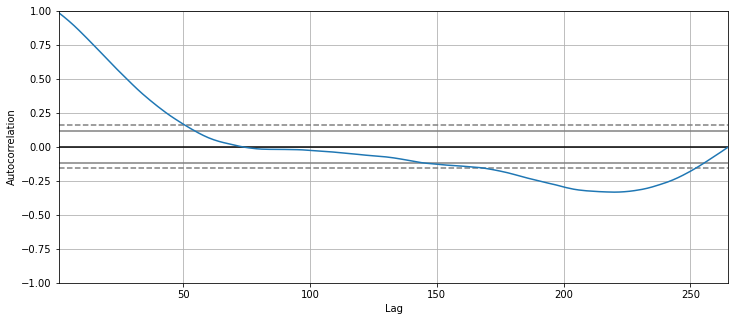

In [50]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(temp97201);

In [58]:
temp97201.isna().sum()

Avg_Price    0
dtype: int64

In [75]:
temp2 = temp97201[98:]
temp2

,Avg_Price
Date,
2004-06-01,592000.0
2004-07-01,591800.0
2004-08-01,591500.0
2004-09-01,591900.0
2004-10-01,593300.0
...,...
2017-12-01,933800.0
2018-01-01,938100.0
2018-02-01,941300.0


In [72]:
print(temp97201.iloc[98])
temp97201.iloc[99]

Avg_Price    592000.0
Name: 2004-06-01 00:00:00, dtype: float64


Avg_Price    591800.0
Name: 2004-07-01 00:00:00, dtype: float64

# Step 5: ARIMA Modeling

In [81]:
# Import ARMA
from statsmodels.tsa.arima_model import ARMA

# Fit an ARMA(1,0) model
mod_arma = ARMA(temp97201, order=(1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:              Avg_Price   No. Observations:                  265
Model:                     ARMA(1, 0)   Log Likelihood               -2640.024
Method:                       css-mle   S.D. of innovations           4949.115
Date:                Fri, 26 Feb 2021   AIC                           5286.049
Time:                        13:50:01   BIC                           5296.788
Sample:                    04-01-1996   HQIC                          5290.364
                         - 04-01-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.197e+05        nan        nan        nan         nan         nan
ar.L1.Avg_Price     1.0000        nan        nan        nan         nan         nan
                                

/Users/Crisitna/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/Crisitna/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [49]:
# Fit an ARMA(2,1) model
mod_arma = ARMA(temp97201, order=(2,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

/Users/Crisitna/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              Avg_Price   No. Observations:                  265
Model:                     ARMA(2, 1)   Log Likelihood               -2339.533
Method:                       css-mle   S.D. of innovations           1612.263
Date:                Fri, 26 Feb 2021   AIC                           4689.066
Time:                        12:13:01   BIC                           4706.965
Sample:                    04-01-1996   HQIC                          4696.258
                         - 04-01-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.197e+05   1.94e+05      3.190      0.002    2.39e+05       1e+06
ar.L1.Avg_Price     1.8484      0.018    102.062      0.000       1.813       1.884
ar.L2.Avg_Price    -0.8489      

# Step 6: Interpreting Results